In [2]:
!pip install easyesn

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 6]
from scipy.stats import cauchy
from easyesn import PredictionESN

Using Numpy backend.


In [57]:
w_0 = 462 # [GHz] Centre frequency

# THESE DIRECTLY RELATE TO THE SCALING FACTORS
sigma_short = 0.33 # [GHz] Timescale of minute (Translates to about 0.8nm deviation)
sigma_long = 0.66 # [GHz] Timescale of hours

laser_linewidth = 10000 # [Hz] maximum
laser_precision = 50*10**6 # [Hz] not sure what this means
spd_efficiency = 0.9 # worst case
spd_jitter = 100*10**-12 # [s]

tau_r = 900*10**-12 # [s] radiative lifetime
h_bar = 1.054571817*10**-34 # [J*s]
linewidth = 1/tau_r
print(linewidth)

1111111111.1111112


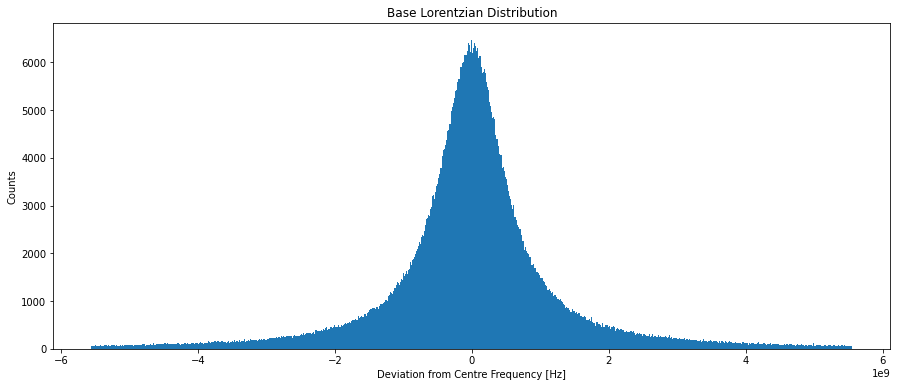

In [58]:
lor = cauchy.rvs(loc=0,scale=linewidth/2,size=1000000)

plt.title("Base Lorentzian Distribution")
plt.xlabel("Deviation from Centre Frequency [Hz]")
plt.ylabel("Counts")
plt.hist(lor,bins=1000,range=(-5*linewidth,5*linewidth));
# Linewidth should be in about the kHz range
# Convert to Frequency from energy

In [33]:
class Spectrum_Simulator:
        def __init__(self, timestep=10**-6, centre=0, FWHM=1):
            self.timestep = timestep
            self.centre = centre
            self.FWHM = FWHM
            self.num_noises = 0
            self.windows = []
            self.stds = []
            self.corrections = []
            self.random = []
            self.smooth = []
            self.smoother = []
            self.smoothest = []
            self.wandering = []
            
        def add_noise(self, window, std):
            self.num_noises += 1
            self.windows.append(window)
            self.stds.append(std)
            self.corrections.append(self.compute_correction(window))
            self.random.append(np.zeros(window))
            self.smooth.append(np.zeros(window))
            self.smoother.append(np.zeros(window))
            self.smoothest.append(np.zeros(window))
                
        def compute_correction(self,window):
            num_steps = 10000*window
            random = np.zeros(window)
            smooth = np.zeros(window)
            smoother = np.zeros(window)
            smoothest = np.zeros(window)
            wandering = np.zeros(num_steps)
            for i in range(num_steps):
                random = np.roll(random,1)
                smooth = np.roll(smooth,1)
                smoother = np.roll(smoother,1)
                smoothest = np.roll(smoothest,1)
                random[0] = np.random.normal(0,1,1)
                smooth[0] = np.sum(random)/window
                smoother[0] = np.sum(smooth)/window
                smoothest[0] = np.sum(smoother)/window
                wandering[i] = np.sum(smoothest)/window
            return np.std(wandering)
        
        def step(self):
            sum = 0
            for noise in range(self.num_noises):
                self.random[noise] = np.roll(self.random[noise],1)
                self.smooth[noise] = np.roll(self.smooth[noise],1)
                self.smoother[noise] = np.roll(self.smoother[noise],1)
                self.smoothest[noise] = np.roll(self.smoothest[noise],1)
                
                self.random[noise][0] = np.random.normal(0,1,1)
                self.smooth[noise][0] = np.sum(self.random[noise])/self.windows[noise]
                self.smoother[noise][0] = np.sum(self.smooth[noise])/self.windows[noise]
                self.smoothest[noise][0] = np.sum(self.smoother[noise])/self.windows[noise]
                
                sum += np.sum(self.smoothest[noise])/self.windows[noise]
                
            self.wandering.append(sum*self.stds[noise]/self.corrections[noise])
            
        def measure_counts(target_freq, boundaries, time):
            
            return
            

In [45]:
timestep = 10**-6 # [s], i.e. each timestep is 1 microsecond
window = 10
std = 1
num_steps = 1000

sim = Spectrum_Simulator(timestep=timestep)
sim.add_noise(window,std)
for i in range(num_steps):
    sim.step()

0.001


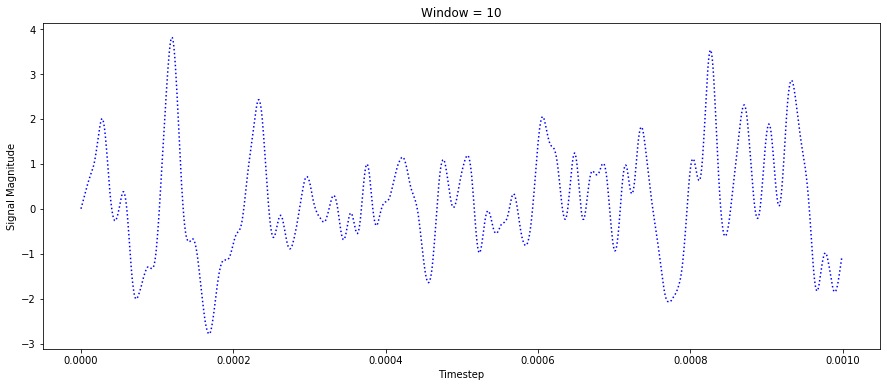

In [60]:
total_time = num_steps*timestep
print(total_time)
times = np.arange(0,total_time,timestep)
times = times[0:np.array(sim.wandering).shape[0]]
f = 10000 # [Hz]

CF = np.array(sim.wandering) + np.sin(2*np.pi*f*times)
#CF = np.sin(2*np.pi*f*times)

plot = True
if plot == True:
    plt.rcParams['figure.figsize'] = [15, 6]
    plt.title("Window = 10")
    plt.xlabel("Timestep")
    plt.ylabel("Signal Magnitude")
    plt.plot(times,CF,linestyle=':',color='b')

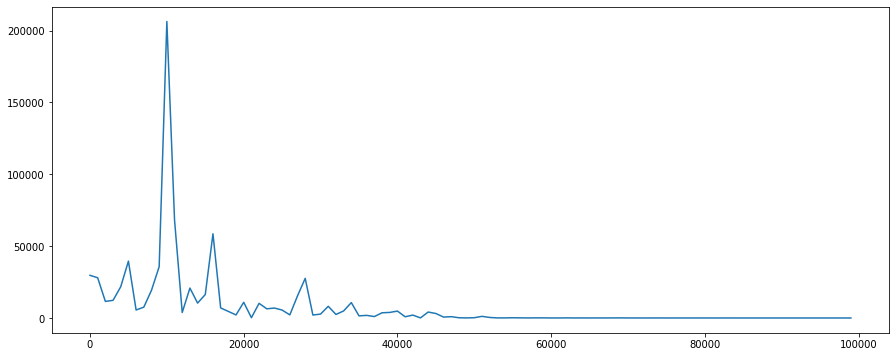

In [61]:
sampling_rate = 1/timestep
time = np.arange(0, num_steps*timestep, timestep)
data = CF
fourier_transform = np.fft.rfft(data)
abs_fourier_transform = np.abs(fourier_transform)
power_spectrum = np.square(abs_fourier_transform)
frequency = np.linspace(0, sampling_rate/2, len(power_spectrum))
plt.plot(frequency[0:100], power_spectrum[0:100])

In [23]:
print(sampling_rate)
print(frequency)

1000000.0
[0.000e+00 1.000e+02 2.000e+02 ... 4.998e+05 4.999e+05 5.000e+05]


In [53]:
x = np.array(sim.wandering[0::1])
y = np.array(sim.wandering[5::1])
len = y.size
train_len = int(0.99*len)
test_len = len-train_len
x_train = x[0:train_len]
y_train = y[0:train_len]
x_test = x[0:test_len]
y_test = y[0:test_len]

In [54]:
esn = PredictionESN(n_input=1, n_output=1, n_reservoir=50, leakingRate=0.2,
                    regressionParameters=[1e-2], solver="lsqr", feedback=False)
esn.fit(x_train, y_train, transientTime="Auto", verbose=1)

100% (98876 of 98876) |##################| Elapsed Time: 0:00:02 Time:  0:00:02


0.2060686493312172

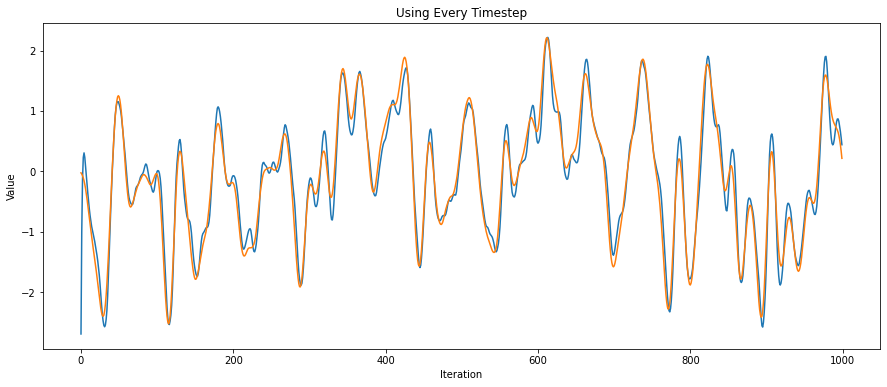

In [56]:
one_step_prediction = esn.predict(x_test)
plt.xlabel("Iteration")
plt.ylabel("Value")
plt.title("Using Every Timestep")
plt.plot(one_step_prediction.T[0,:])
plt.plot(y_test)
plt.show()

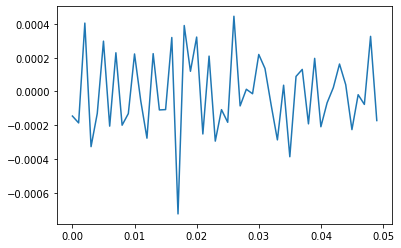

In [26]:
from __future__ import division
import numpy as np

#FFT engines
from numpy.fft import rfftfreq,irfft

#Interpolation
from scipy import interpolate

#Units 
from astropy.units import s,Hz,kHz

########################################################
########GaussianNoiseGenerator class####################
########################################################

class GaussianNoiseGenerator(object):

    def __init__(self,recording_time=100.0,sampling_frequency=1000):
        
        self.sampling_frequency = sampling_frequency
        self.recording_time = recording_time
        self.nsamples = int(recording_time*sampling_frequency)
    
    def _fourierMap(self,power_func,**kwargs):

        #Resolution in Fourier space
        fmin = 2.0*np.pi/self.recording_time
        f = rfftfreq(self.nsamples) * fmin

        #Compute the power spectrum at each l and check that it is positive 
        if isinstance(power_func,np.ndarray):
            
            #Check for correct shape
            assert power_func.shape[0] == 2,"If you want an interpolated power spectrum you should pass a (fs,Pfs) array!"

            #Perform the interpolation
            fs,Pfs = power_func
            power_interp = interpolate.interp1d(fs,Pfs,**kwargs)
            Pf = power_interp(f)

        else:
            Pf = power_func(f,**kwargs)

        #Generate real and imaginary part
        real_part = np.sqrt(0.5*Pf) * np.random.normal(loc=0.0,scale=1.0,size=f.shape)
        imaginary_part = np.sqrt(0.5*Pf) * np.random.normal(loc=0.0,scale=1.0,size=f.shape)

        return real_part + imaginary_part*1.0j



    def fromPowerSpectrum(self,power_func,seed=0,**kwargs):

        """
        This method uses a supplied power spectrum to generate correlated noise maps in real space via FFTs
        :param power_func: function that given a numpy array of l's returns a numpy array with the according Pl's (this is the input power spectrum); alternatively you can pass an array (l,Pl) and the power spectrum will be calculated with scipy's interpolation routines
        :type power_func: function with the above specifications, or numpy array (l,Pl) of shape (2,n) 
        :param seed: seed of the random generator 
        :type seed: int.
        :param kwargs: keyword arguments to be passed to power_func, or to the interpolate.interp1d routine
        :returns: the simulated timestream with the required power spectrum
        """

        #Initialize random number generator
        np.random.seed(seed)

        #Generate a random Fourier realization and invert it
        ft_map = self._fourierMap(power_func,**kwargs)
        noise_map = irfft(ft_map)

        return np.linspace(0.0,self.recording_time,self.nsamples),noise_map



#####################################################################
#############Test driver#############################################
#####################################################################

def power1(f,n):
    return 1.0 / (1.0 + f)**n

power2 = np.array([[0, 0.5, 1, 1.5, 2, 2.5, 3], [0, 0.2, 0.3, 0.5, 0.4, 0.1, 0]])

generator = GaussianNoiseGenerator()
t,y = generator.fromPowerSpectrum(power2,seed=0)
plt.plot(t[0:50],y[0:50])

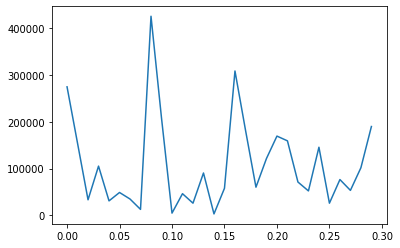

In [29]:
sampling_rate = 1000

time = np.arange(0, 100, 1/sampling_rate)

data = np.sin(2*np.pi*6*time) + np.random.randn(len(time))

fourier_transform = np.fft.rfft(data)

abs_fourier_transform = np.abs(fourier_transform)

power_spectrum = np.square(abs_fourier_transform)

frequency = np.linspace(0, sampling_rate/2, len(power_spectrum))

plt.plot(frequency[0:30], power_spectrum[0:30])

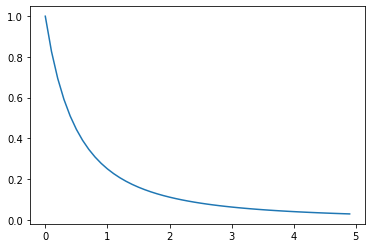

In [20]:
x = np.arange(0,5,0.1)
y = power(x,2)
plt.plot(x,y)